<a href="https://colab.research.google.com/github/ambideXtrous9/Image-Classification-CIFAR-10/blob/main/CIFAR_10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow_datasets as tfds
import tensorflow as tf
# import the necessary packages
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2,InceptionV3,VGG16,MobileNetV3Large
from tensorflow.keras.layers import AveragePooling2D,Dropout,Convolution2D,MaxPooling2D
from tensorflow.keras.layers import Dropout,BatchNormalization,Conv2D
from tensorflow.keras.layers import Flatten,Activation
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras import Sequential
from tensorflow.keras.optimizers import Adam,SGD
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import argparse
import os
import keras
import cv2
from google.colab.patches import cv2_imshow
import tarfile
import pandas as pd
from google.colab.patches import cv2_imshow
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sn

In [2]:
_URL = 'https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz'

In [3]:
zip_dir = tf.keras.utils.get_file('/content/CIFAR-10', origin=_URL, untar=True,extract=True)

170500096/170498071 [==============================] - 3s 0us/step


In [4]:
fname = '/content/CIFAR-10.tar.gz'

In [5]:
if fname.endswith("tar.gz"):
    tar = tarfile.open(fname)
    tar.extractall()
    tar.close()

In [6]:
def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        cifar_dict = pickle.load(fo, encoding='bytes')
    return cifar_dict

In [7]:
dirs = ['batches.meta','data_batch_1','data_batch_2','data_batch_3','data_batch_4','data_batch_5','test_batch']

In [8]:
all_data = [0,1,2,3,4,5,6]

In [9]:
CIFAR_DIR = '/content/cifar-10-batches-py/'

In [10]:
for i,direc in zip(all_data,dirs):
    all_data[i] = unpickle(CIFAR_DIR+direc)

In [11]:
batch_meta = all_data[0]
data_batch1 = all_data[1]
data_batch2 = all_data[2]
data_batch3 = all_data[3]
data_batch4 = all_data[4]
data_batch5 = all_data[5]
test_batch = all_data[6]

In [12]:
batch_meta


{b'label_names': [b'airplane',
  b'automobile',
  b'bird',
  b'cat',
  b'deer',
  b'dog',
  b'frog',
  b'horse',
  b'ship',
  b'truck'],
 b'num_cases_per_batch': 10000,
 b'num_vis': 3072}

In [13]:
label_names = batch_meta[b'label_names']

In [14]:
label_names = [x.decode('utf-8') for x in label_names]

In [15]:
label_names

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

In [16]:
data_batch1.keys()

dict_keys([b'batch_label', b'labels', b'data', b'filenames'])

In [17]:
train_data = np.concatenate([data_batch1[b'data'],data_batch2[b'data'],data_batch3[b'data'],data_batch4[b'data'],data_batch5[b'data']],axis=0)
train_labels = np.concatenate([data_batch1[b'labels'],data_batch2[b'labels'],data_batch3[b'labels'],data_batch4[b'labels'],data_batch5[b'labels']],axis=0)

In [18]:
train_data.shape

(50000, 3072)

In [19]:
train_labels.shape

(50000,)

In [20]:
#Preparing test data
test_data = test_batch[b'data']
test_labels = test_batch[b'labels']

In [21]:
test_data.shape

(10000, 3072)

In [22]:
# Reshaping data
train_data = train_data.reshape(50000, 3, 32, 32).transpose(0, 2, 3, 1).astype("float32")
test_data = test_data.reshape(10000, 3, 32, 32).transpose(0, 2, 3, 1).astype("float32")

In [23]:
# Normalize the input 
train_data /= 255
test_data /= 255

In [24]:
train_data.shape

(50000, 32, 32, 3)

In [25]:
def showimg(i):
    plt.imshow(train_data[i])
    print(label_names[train_labels[i]])

In [26]:
len(train_labels)

50000

automobile


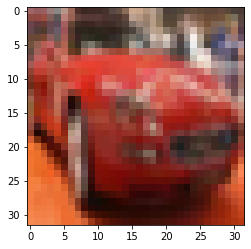

In [29]:
showimg(5)

In [30]:
Y_train = []
for i in range(len(train_labels)):
    Y_train.append(label_names[train_labels[i]])

In [31]:
Y_train = np.array(Y_train)

In [32]:
len(Y_train)

50000

In [33]:
Y_test = []
for i in range(len(test_labels)):
    Y_test.append(label_names[test_labels[i]])

In [34]:
Y_test = np.array(Y_test)

In [35]:
len(Y_test)

10000

In [36]:
IMG_SIZE = 32
INIT_LR = 1e-5
EPOCHS =  100
BS = 8
NUM_CLASSES = 10

In [37]:
from keras.utils import np_utils

In [38]:
# Convert class vectors to binary class matrices.
y_train = np_utils.to_categorical(train_labels,NUM_CLASSES)
y_test = np_utils.to_categorical(test_labels,NUM_CLASSES)

In [39]:
y_train.shape

(50000, 10)

In [40]:
y_test.shape

(10000, 10)

In [41]:
model = Sequential()

model.add(Conv2D(32, (3, 3), padding='same',input_shape=train_data.shape[1:]))
model.add(Activation('relu'))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# CONV => RELU => CONV => RELU => POOL => DROPOUT
model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))

model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# FLATTERN => DENSE => RELU => DROPOUT
model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))

model.add(Dense(NUM_CLASSES, activation='softmax'))
#sgd = SGD(lr=INIT_LR,momentum=0.9,nesterov=False)
model.compile(loss="categorical_crossentropy", optimizer='adam',metrics=["accuracy"])

In [42]:
H = model.fit(train_data,y_train,
              validation_data = (test_data,y_test),
              epochs=EPOCHS)

Epoch 1/100
1563/1563 [==============================] - 40s 5ms/step - loss: 1.5593 - accuracy: 0.4298 - val_loss: 1.1852 - val_accuracy: 0.5718
Epoch 2/100
1563/1563 [==============================] - 8s 5ms/step - loss: 1.1732 - accuracy: 0.5840 - val_loss: 0.9946 - val_accuracy: 0.6527
Epoch 3/100
1563/1563 [==============================] - 8s 5ms/step - loss: 1.0120 - accuracy: 0.6447 - val_loss: 0.9473 - val_accuracy: 0.6753
Epoch 4/100
1563/1563 [==============================] - 8s 5ms/step - loss: 0.9198 - accuracy: 0.6786 - val_loss: 0.8262 - val_accuracy: 0.7155
Epoch 5/100
1563/1563 [==============================] - 8s 5ms/step - loss: 0.8614 - accuracy: 0.6975 - val_loss: 0.8009 - val_accuracy: 0.7227
Epoch 6/100
1563/1563 [==============================] - 8s 5ms/step - loss: 0.8039 - accuracy: 0.7174 - val_loss: 0.7300 - val_accuracy: 0.7485
Epoch 7/100
1563/1563 [==============================] - 8s 5ms/step - loss: 0.7687 - accuracy: 0.7306 - val_loss: 0.7167 - val_a

In [46]:
model.save('CIFAR-10_Adam.model', save_format="h5")

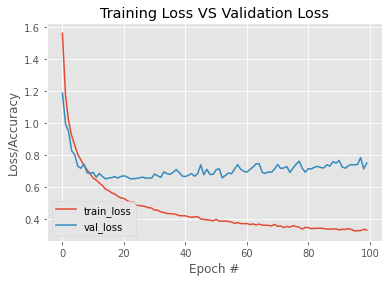

<Figure size 432x288 with 0 Axes>

In [43]:
# plot the training loss and accuracy
N = EPOCHS
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.title("Training Loss VS Validation Loss")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.show()
plt.savefig('graph.png')

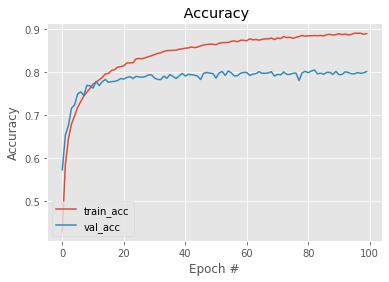

In [44]:
N = EPOCHS
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
plt.title(" Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Accuracy")
plt.legend(loc="lower left")
plt.show()

Confusion Matrix on Test Set


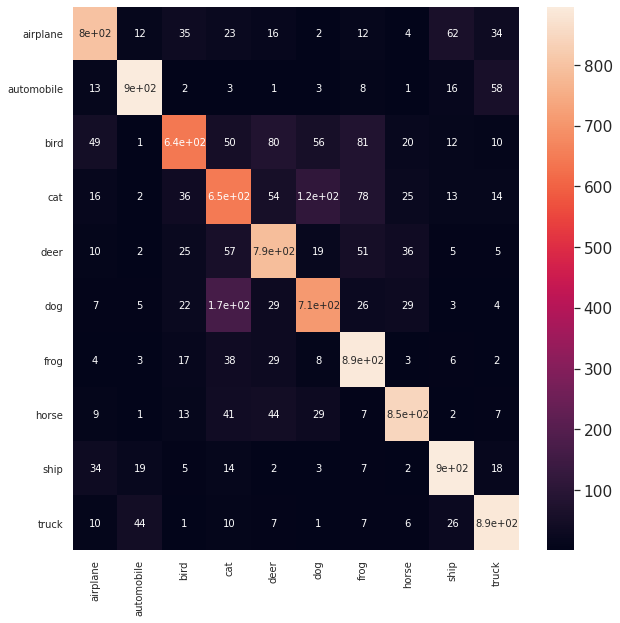

In [45]:
print('Confusion Matrix on Test Set')
pred = model.predict(x=test_data)
pred = np.argmax(pred, axis=1)
cm = confusion_matrix(test_labels, pred)
df_cm = pd.DataFrame(cm, range(NUM_CLASSES), range(NUM_CLASSES))
plt.figure(figsize=(10,10))
sn.set(font_scale=1.4) # for label size
ax = sn.heatmap(df_cm, annot=True, annot_kws={"size": 10}) # font size
ax.set_xticklabels(label_names, rotation='vertical', fontsize=10)
ax.set_yticklabels(label_names, rotation='horizontal', fontsize=10)
plt.show()

deer


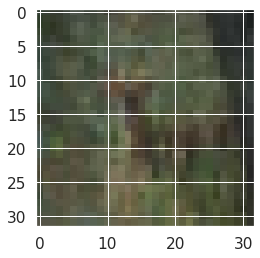

In [74]:
showimg(10)

In [91]:
label_names

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

In [87]:
def predimageTest(path,y):
    plt.imshow(path)
    test = img_to_array(path)
    test = np.expand_dims(test,axis=0) 
    result = model.predict(test,batch_size = BS)
    y_class = result.argmax(axis=1)
    result = (result*100)
    result = list(np.around(np.array(result),2))
    i = y_class[0]
    s = result[0][i]
    plt.text(0, 0,y[i],size=12,color='purple')
    plt.text(0, 50,s,size=15,color='red')
    print(result)
    print(y[i])

[array([ 0.  ,  0.  ,  0.  ,  0.  ,  1.28,  0.  , 98.71,  0.  ,  0.  ,
        0.  ], dtype=float32)]
frog


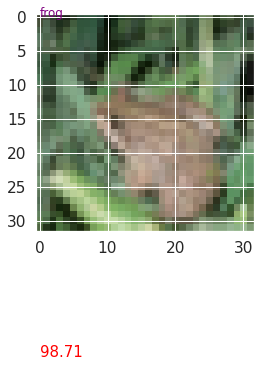

In [88]:
predimageTest(test_data[4],label_names)

In [98]:
def predimage(path,y):
    from PIL import Image,ImageDraw
    image = Image.open(path)
    test = load_img(path,target_size=(IMG_SIZE,IMG_SIZE))
    test = img_to_array(test)
    test = np.expand_dims(test,axis=0)
    test /= 255 
    result = model.predict(test,batch_size = BS)
    y_class = result.argmax(axis=1)
    result = (result*100)
    result = list(np.around(np.array(result),2))
    i = y_class[0]
    s = result[0][i]
    plt.text(0, 0,y[i],size=20,color='purple')
    plt.text(0, 100,s,size=15,color='green')
    plt.imshow(image)
    print(result)
    print(y[i])

[array([  0., 100.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
      dtype=float32)]
automobile


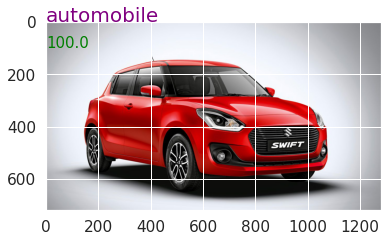

In [99]:
predimage('/content/car.jpg',label_names)

[array([0.000e+00, 0.000e+00, 1.580e+00, 1.000e-01, 7.581e+01, 8.000e-02,
       2.241e+01, 2.000e-02, 0.000e+00, 0.000e+00], dtype=float32)]
deer


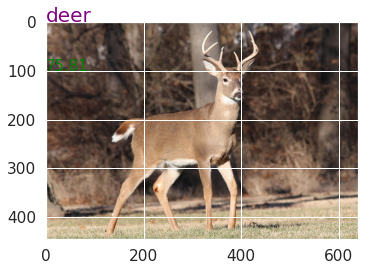

In [100]:
predimage('/content/deer.jpg',label_names)

[array([8.500e-01, 1.280e+00, 1.000e-02, 5.000e-02, 1.000e-02, 2.000e-02,
       1.300e-01, 0.000e+00, 9.292e+01, 4.720e+00], dtype=float32)]
ship


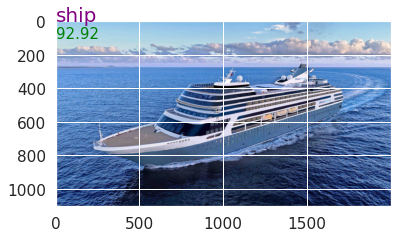

In [101]:
predimage('/content/ship.png',label_names)

[array([9.000e-02, 0.000e+00, 1.000e-02, 7.730e+01, 4.000e-02, 1.410e+00,
       2.000e-01, 1.554e+01, 4.000e-02, 5.360e+00], dtype=float32)]
cat


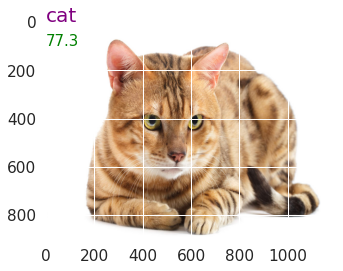

In [102]:
predimage('/content/cat.jpg',label_names)

[array([0.000e+00, 0.000e+00, 6.000e-02, 0.000e+00, 1.404e+01, 2.400e-01,
       5.800e-01, 8.491e+01, 0.000e+00, 1.800e-01], dtype=float32)]
horse


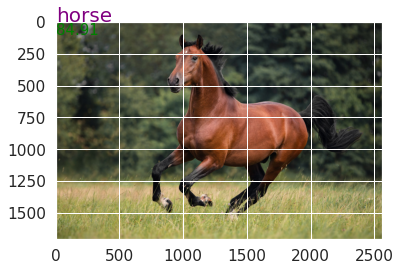

In [103]:
predimage('/content/hrs.jpeg',label_names)

[array([  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0., 100.],
      dtype=float32)]
truck


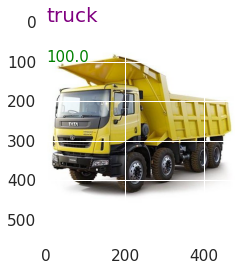

In [104]:
predimage('/content/trk.jpg',label_names)

[array([9.636e+01, 4.800e-01, 3.100e-01, 0.000e+00, 2.800e-01, 0.000e+00,
       0.000e+00, 0.000e+00, 2.530e+00, 4.000e-02], dtype=float32)]
airplane


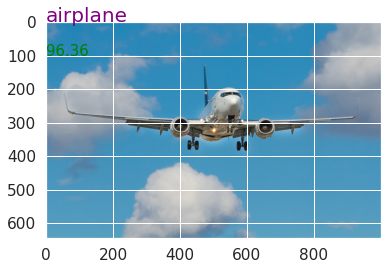

In [106]:
predimage('/content/arp.jpg',label_names)